In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys
import glob

# Precinct Shapefile
---
## VEST's Documentation File

Election results from New Mexico Secretary of State (http://electionresults.sos.state.nm.us/)
Precinct shapefiles primarily from the New Mexico Legislature's Redistricting Website (https://www.nmlegis.gov/Redistricting/)
Lincoln, Los Alamos, McKinley, Sandoval, Socorro from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release.

Santa Fe County precincts 86/89 and 82/90 were split to match the 2018 county PDF map. Several precincts in Roosevelt County were renumbered to match the 2018 election reports.

* G18USSDHEI - Martin T. Heinrich (Democratic Party)
* G18USSRRIC - Mick Rich (Republican Party)
* G18USSLJOH - Gary E. Johnson (Libertarian Party)


* G18GOVDLUJ - Michelle Lujan Grisham (Democratic Party)
* G18GOVRPEA - Steve Pearce (Republican Party)


* G18ATGDBAL - Hector Balderas (Democratic Party)
* G18ATGRHEN - Michael Eugene Hendricks (Republican Party)
* G18ATGLDUN - A. Blair Dunn (Libertarian Party)


* G18SOSDTOU - Maggie Toulouse Oliver (Democratic Party)
* G18SOSRCLA - Gavin S. Clarkson (Republican Party)
* G18SOSLGRI - Ginger G. Grider (Libertarian Party)


* G18TREDEIC - Tim Eichenberg (Democratic Party)
* G18TRERCAS - Arthur L. Castillo (Republican Party)


* G18AUDDCOL - Brian S. Colón (Democratic Party)
* G18AUDRJOH - Wayne A. Johnson (Republican Party)


* G18LNDDGAR - Stephanie Garcia Richard (Democratic Party)
* G18LNDRLYO - Patrick H. Lyons (Republican Party)
* G18LNDLLUC - Michael G. Lucero (Libertarian Party)


* G18SSCDVIG - Michael E. Vigil (Democratic Party)
* G18SSCRCLI - Gary L. Clingman (Republican Party)


* G18SACDBOG - Kristina Bogardus (Democratic Party)
* G18SACRFRE - Stephen G. French (Republican Party)


* G18SACDMED - Jacqueline R. Medina (Democratic Party)
* G18SACRBOH - Hank Bohnhoff (Republican Party)


* G18SACDZAM - Briana H. Zamora (Democratic Party)
* G18SACRKIE - Emil J. Kiehne (Republican Party)


* G18SACDDUF - Megan P. Duffy (Democratic Party)
* G18SACRGAL - Daniel Jose Gallegos (Republican Party)


* G18SACDATT - Jennifer L. Attrep (Democratic Party)

## Load in VEST's Final File

In [2]:
vest_shp = gp.read_file("./raw-from-source/VEST/nm_2018/nm_2018.shp")

In [3]:
vest_shp.shape

(1492, 33)

In [4]:
vest_shp.head(1)

,COUNTYFP,VTDST,NAMELSAD,G18USSDHEI,G18USSRRIC,G18USSLJOH,G18GOVDLUJ,G18GOVRPEA,G18ATGDBAL,G18ATGRHEN,...,G18SACDBOG,G18SACRFRE,G18SACDMED,G18SACRBOH,G18SACDZAM,G18SACRKIE,G18SACDDUF,G18SACRGAL,G18SACDATT,geometry
0,003,6,Catron County Precinct 6,30,57,8,29,65,29,53,...,30,64,30,64,30,65,31,64,52,"POLYGON Z ((-108.71685 33.98629 0.00000, -108...."


<AxesSubplot:>

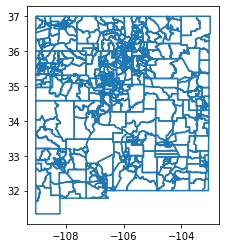

In [5]:
vest_shp.boundary.plot()

In [6]:
vest_shp.columns

Index(['COUNTYFP', 'VTDST', 'NAMELSAD', 'G18USSDHEI', 'G18USSRRIC',
       'G18USSLJOH', 'G18GOVDLUJ', 'G18GOVRPEA', 'G18ATGDBAL', 'G18ATGRHEN',
       'G18ATGLDUN', 'G18SOSDTOU', 'G18SOSRCLA', 'G18SOSLGRI', 'G18TREDEIC',
       'G18TRERCAS', 'G18AUDDCOL', 'G18AUDRJOH', 'G18LNDDGAR', 'G18LNDRLYO',
       'G18LNDLLUC', 'G18SSCDVIG', 'G18SSCRCLI', 'G18SACDBOG', 'G18SACRFRE',
       'G18SACDMED', 'G18SACRBOH', 'G18SACDZAM', 'G18SACRKIE', 'G18SACDDUF',
       'G18SACRGAL', 'G18SACDATT', 'geometry'],
      dtype='object')

## Loading, Combining Election Results
The SOS directed to this link for election results for the 2016 general: (http://electionresults.sos.state.nm.us/) 
The updated link for 2016 general election results: (https://electionresults.sos.state.nm.us/?eid=84)

In [20]:
folder = os.listdir("./raw-from-source/Election_Results/")

files = []
for file in folder:
    if "Precinct" in file:
        election = pd.ExcelFile("./raw-from-source/Election_Results/" + file)
        counties = election.sheet_names
        df_election = []
        for county in counties: 
            df = pd.read_excel(election, sheet_name = county, skiprows=[0,1,2,3,4,5])
            df = df.loc[:, df.columns != df.columns[0]]
            df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
            df_election.append(df)
        combined_df_election = pd.concat(df_election)
        combined_df_election.reset_index(drop=True,inplace=True)
        files.append(combined_df_election)
nm_18 = pd.concat(files, axis = 1)

nm_18 = nm_18.rename(columns = {'MICK RICH':'G18USSRRIC', 
                                'MARTIN T HEINRICH':'G18USSDHEI',
                                'GARY E JOHNSON':'G18USSLJOH', 
                                'HECTOR BALDERAS':'G18ATGDBAL', 
                                'MICHAEL EUGENE HENDRICKS':'G18ATGRHEN',
                                'A BLAIR DUNN':'G18ATGLDUN', 
                                'WAYNE A JOHNSON':'G18AUDRJOH', 
                                'BRIAN S COLÓN':'G18AUDDCOL',
                                'MICHELLE LUJAN GRISHAM AND HOWIE C MORALES':'G18GOVDLUJ',
                                'STEVE PEARCE AND MICHELLE GARCIA HOLMES':'G18GOVRPEA', 
                                'STEPHANIE GARCIA RICHARD':'G18LNDDGAR',
                                'PATRICK H LYONS':'G18LNDRLYO', 
                                'MICHAEL G LUCERO':'G18LNDLLUC', 
                                'KRISTINA BOGARDUS':'G18SACDBOG',
                                'STEPHEN G FRENCH':'G18SACRFRE', 
                                'HANK BOHNHOFF':'G18SACRBOH', 
                                'JACQUELINE R MEDINA':'G18SACDMED',
                                'BRIANA H ZAMORA':'G18SACDZAM', 
                                'EMIL J KIEHNE':'G18SACRKIE', 
                                'MEGAN P DUFFY':'G18SACDDUF',
                                'DANIEL JOSE GALLEGOS':'G18SACRGAL', 
                                'JENNIFER L ATTREP':'G18SACDATT', 
                                'MAGGIE TOULOUSE OLIVER':'G18SOSDTOU',
                                'GAVIN S CLARKSON':'G18SOSRCLA', 
                                'GINGER G GRIDER':'G18SOSLGRI', 
                                'GARY L CLINGMAN':'G18SSCRCLI',
                                'MICHAEL E VIGIL':'G18SSCDVIG', 
                                'ARTHUR L CASTILLO':'G18TRERCAS', 
                                'TIM EICHENBERG':'G18TREDEIC'})

nm_18 = nm_18[['County','Precinct','G18USSDHEI', 'G18USSRRIC',
       'G18USSLJOH', 'G18GOVDLUJ', 'G18GOVRPEA', 'G18ATGDBAL', 'G18ATGRHEN',
       'G18ATGLDUN', 'G18SOSDTOU', 'G18SOSRCLA', 'G18SOSLGRI', 'G18TREDEIC',
       'G18TRERCAS', 'G18AUDDCOL', 'G18AUDRJOH', 'G18LNDDGAR', 'G18LNDRLYO',
       'G18LNDLLUC', 'G18SSCDVIG', 'G18SSCRCLI', 'G18SACDBOG', 'G18SACRFRE',
       'G18SACDMED', 'G18SACRBOH', 'G18SACDZAM', 'G18SACRKIE', 'G18SACDDUF',
       'G18SACRGAL', 'G18SACDATT']]

nm_18 = nm_18.loc[:,~nm_18.columns.duplicated()]

nm_18 = nm_18[nm_18["Precinct"]!="TOTALS"]

# Fill n/a values with 0
nm_18 = nm_18.fillna(0)
nm_18 = nm_18.replace(to_replace="*", value = 0)

# Display results in alphabetical order of the counties
nm_18 = nm_18.sort_values(by = ['County', 'Precinct'], ascending = True)


# Change strings to integers (County and Precinct columns remain unchanged)
nm_18 = nm_18.apply(pd.to_numeric, errors='ignore')

# Deal with the index 
nm_18.reset_index(drop=True,inplace=True)

nm_18


,County,Precinct,G18USSDHEI,G18USSRRIC,G18USSLJOH,G18GOVDLUJ,G18GOVRPEA,G18ATGDBAL,G18ATGRHEN,G18ATGLDUN,...,G18SSCRCLI,G18SACDBOG,G18SACRFRE,G18SACDMED,G18SACRBOH,G18SACDZAM,G18SACRKIE,G18SACDDUF,G18SACRGAL,G18SACDATT
0,Bernalillo,PCT 001,366,224,123,397,317,443,242,25,...,302,366,330,379,315,374,320,365,326,480
1,Bernalillo,PCT 002,268,196,81,287,257,328,192,25,...,252,258,271,280,251,276,253,259,270,363
2,Bernalillo,PCT 003,406,210,126,435,305,464,231,42,...,312,390,333,413,309,415,308,393,327,515
3,Bernalillo,PCT 004,280,128,103,294,217,323,152,30,...,190,264,228,260,224,281,213,264,225,321
4,Bernalillo,PCT 005,306,109,78,317,169,346,125,18,...,157,293,182,305,171,322,156,283,191,357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487,Valencia,PRECINCT 37,165,128,41,162,171,191,127,14,...,162,164,165,165,163,161,168,160,168,219
1488,Valencia,PRECINCT 38,234,207,81,239,281,288,212,20,...,261,239,274,255,259,249,268,242,272,340
1489,Valencia,PRECINCT 39,609,480,210,626,668,747,481,62,...,622,609,656,632,632,602,671,582,681,858
1490,Valencia,PRECINCT 40,359,242,114,350,363,433,249,30,...,318,343,357,376,324,343,364,339,361,475


## Validating Election Results

### Check Statewide Candidate Totals

In [21]:
data_columns = ['G18USSDHEI', 'G18USSRRIC',
       'G18USSLJOH', 'G18GOVDLUJ', 'G18GOVRPEA', 'G18ATGDBAL', 'G18ATGRHEN',
       'G18ATGLDUN', 'G18SOSDTOU', 'G18SOSRCLA', 'G18SOSLGRI', 'G18TREDEIC',
       'G18TRERCAS', 'G18AUDDCOL', 'G18AUDRJOH', 'G18LNDDGAR', 'G18LNDRLYO',
       'G18LNDLLUC', 'G18SSCDVIG', 'G18SSCRCLI', 'G18SACDBOG', 'G18SACRFRE',
       'G18SACDMED', 'G18SACRBOH', 'G18SACDZAM', 'G18SACRKIE', 'G18SACDDUF',
       'G18SACRGAL', 'G18SACDATT']
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

In [22]:
statewide_totals_check(vest_shp,nm_18,data_columns)

***Statewide Totals Check***
G18USSDHEI has a difference of 41 votes
	VEST: 376998 votes
	SOURCES: 376957 votes
G18USSRRIC has a difference of 41 votes
	VEST: 212813 votes
	SOURCES: 212772 votes
G18USSLJOH has a difference of 75 votes
	VEST: 107201 votes
	SOURCES: 107126 votes
G18GOVDLUJ has a difference of 53 votes
	VEST: 398368 votes
	SOURCES: 398315 votes
G18GOVRPEA has a difference of 28 votes
	VEST: 298091 votes
	SOURCES: 298063 votes
G18ATGDBAL has a difference of 65 votes
	VEST: 427583 votes
	SOURCES: 427518 votes
G18ATGRHEN has a difference of 25 votes
	VEST: 231296 votes
	SOURCES: 231271 votes
G18ATGLDUN has a difference of 463 votes
	VEST: 32931 votes
	SOURCES: 32468 votes
G18SOSDTOU has a difference of 41 votes
	VEST: 399134 votes
	SOURCES: 399093 votes
G18SOSRCLA has a difference of 31 votes
	VEST: 257306 votes
	SOURCES: 257275 votes
G18SOSLGRI has a difference of 349 votes
	VEST: 34527 votes
	SOURCES: 34178 votes
G18TREDEIC has a difference of 30 votes
	VEST: 394780 votes


### Check County Totals

#### County FIPs Data 

In [29]:
# Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="New Mexico"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

# Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

# Create the dictionary
fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

# # Modify county names in dataframe to match the FIPs file
# county_name_changes_dict = {"LaMoure":"Lamoure","McKenzie":"Mckenzie","McLean":"Mclean"}
# nm_16["County"] = nm_16["County"].map(county_name_changes_dict).fillna(nm_16["County"])

# Use the dictionary to go from a county name to a county FIPS
nm_18["COUNTYFP"] = nm_18["County"].map(fips_dict).fillna(nm_18["County"])

# Check the number of counties - looking for 33
print(len(nm_18["COUNTYFP"].unique()))

33
